In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 61.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving incidents_train.csv to incidents_train.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving incidents.csv to incidents.csv


Cleaned Training Data Sample:
   Unnamed: 0  year  month  day country                            title  \
0           0  1994      1    7      us  recall notification fsis-024 94   
1           1  1994      3   10      us  recall notification fsis-033 94   
2           2  1994      3   28      us  recall notification fsis-014 94   
3           3  1994      4    3      us  recall notification fsis-009 94   
4           4  1994      7    1      us  recall notification fsis-001 94   

                                                text hazard-category  \
0  case number 024 94   \n             date open ...      biological   
1  case number 033 94   \n             date open ...      biological   
2  case number 014 94   \n             date open ...      biological   
3  case number 009 94   \n             date open ...  foreign bodies   
4  case number 001 94   \n             date open ...  foreign bodies   

               product-category                  hazard  \
0  meat, egg and dair

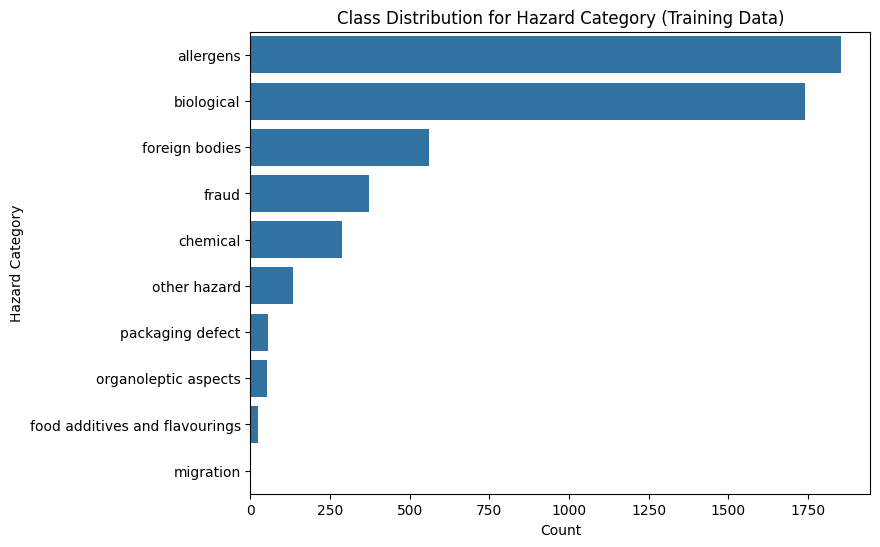

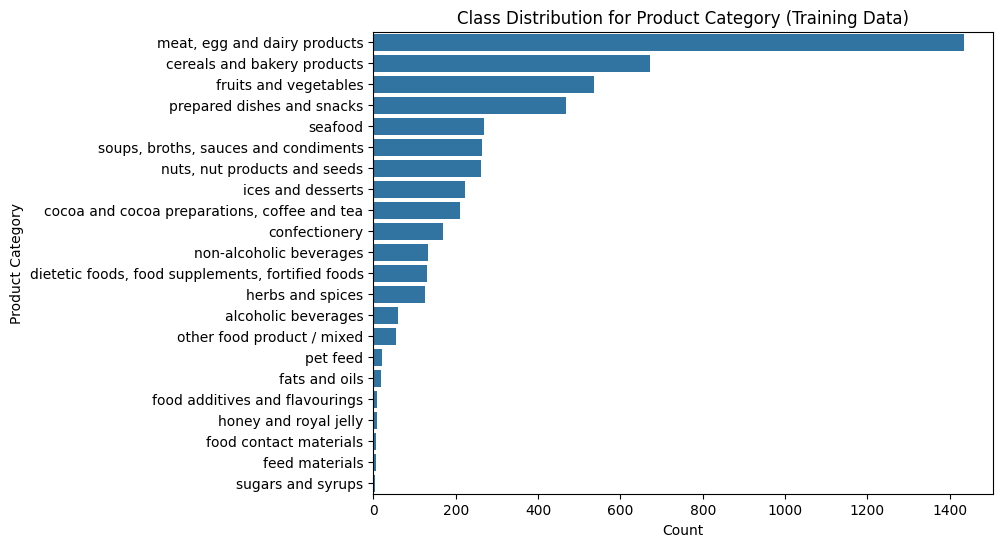

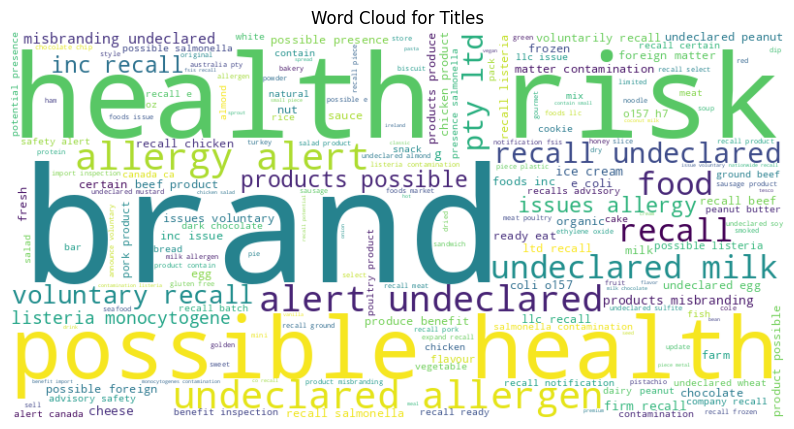

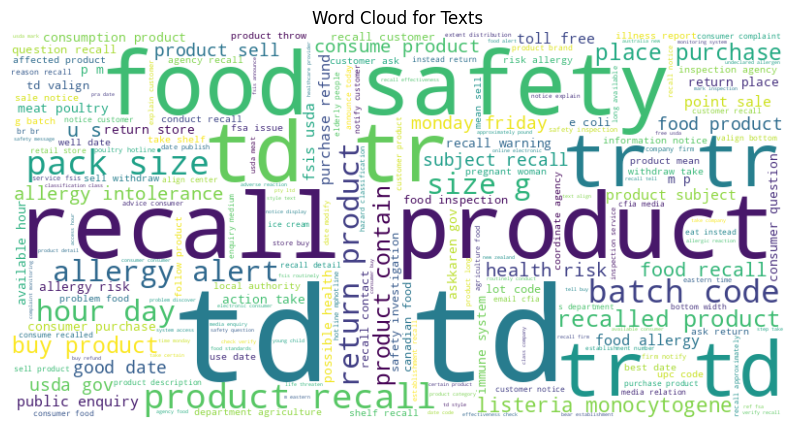

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from xgboost import XGBClassifier
from gensim.models import Word2Vec
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

nlp = spacy.load("en_core_web_sm")


# Data Cleaning

def clean_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Loading Data
train_data = pd.read_csv("/content/incidents_train.csv")
test_data = pd.read_csv("/content/incidents.csv")

# Applying Cleaning
train_data['title'] = train_data['title'].apply(clean_text)
train_data['text'] = train_data['text'].apply(clean_text)
test_data['title'] = test_data['title'].apply(clean_text)
test_data['text'] = test_data['text'].apply(clean_text)

# Displaying Cleaned Data Samples
print("Cleaned Training Data Sample:")
print(train_data.head())
print("\nCleaned Testing Data Sample:")
print(test_data.head())

# Visualizations
plt.figure(figsize=(8, 6))
sns.countplot(y='hazard-category', data=train_data, order=train_data['hazard-category'].value_counts().index)
plt.title("Class Distribution for Hazard Category (Training Data)")
plt.xlabel("Count")
plt.ylabel("Hazard Category")
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(y='product-category', data=train_data, order=train_data['product-category'].value_counts().index)
plt.title("Class Distribution for Product Category (Training Data)")
plt.xlabel("Count")
plt.ylabel("Product Category")
plt.show()

# Word Cloud for Titles
plt.figure(figsize=(10, 6))
wordcloud_title = WordCloud(width=800, height=400, background_color="white").generate(" ".join(train_data['title']))
plt.imshow(wordcloud_title, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Titles")
plt.show()

# Word Cloud for Texts
plt.figure(figsize=(10, 6))
wordcloud_text = WordCloud(width=800, height=400, background_color="white").generate(" ".join(train_data['text']))
plt.imshow(wordcloud_text, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Texts")
plt.show()




ST1

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import zipfile

# Custom Scoring Function
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
    # Computing F1 for hazards
    f1_hazards = f1_score(hazards_true, hazards_pred, average='macro')

    # Computing F1 for products where hazards are correct
    f1_products = f1_score(
        products_true[hazards_pred == hazards_true],
        products_pred[hazards_pred == hazards_true],
        average='macro'
    )

    # Returning the combined score
    return (f1_hazards + f1_products) / 2

# Feature Engineering with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=500, class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42)
}

# Handling Imbalance with SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)

# K-Fold Cross Validation
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Preparing submission directory
os.makedirs("submission_ST1", exist_ok=True)

# Train and Prediction
submission_df_title = pd.DataFrame()
submission_df_text = pd.DataFrame()

for feature in ['title', 'text']:
    print(f"\nUsing feature: {feature}")

    # Vectorizing data
    X = vectorizer.fit_transform(train_data[feature])
    test_X = vectorizer.transform(test_data[feature])

    # Preparing ground truth for both tasks
    hazards_true = LabelEncoder().fit_transform(train_data['hazard-category'])
    products_true = LabelEncoder().fit_transform(train_data['product-category'])

    best_hazard_model, best_product_model = None, None
    best_score = 0

    for hazard_model_name, hazard_model in models.items():
        for product_model_name, product_model in models.items():
            fold_scores = []

            for train_idx, test_idx in kf.split(X, hazards_true):
                # Train-Test Split
                X_train, X_test = X[train_idx], X[test_idx]
                hazards_train, hazards_test = hazards_true[train_idx], hazards_true[test_idx]
                products_train, products_test = products_true[train_idx], products_true[test_idx]

                # Applying SMOTE for both tasks
                X_train_hazards_res, hazards_train_res = smote.fit_resample(X_train, hazards_train)
                X_train_products_res, products_train_res = smote.fit_resample(X_train, products_train)

                # Training hazard and product models
                hazard_model.fit(X_train_hazards_res, hazards_train_res)
                product_model.fit(X_train_products_res, products_train_res)

                # Predicting hazards and products
                hazards_pred = hazard_model.predict(X_test)
                products_pred = product_model.predict(X_test)

                # Computing custom score
                score = compute_score(hazards_test, products_test, hazards_pred, products_pred)
                fold_scores.append(score)

            avg_score = np.mean(fold_scores)
            print(f"Models: {hazard_model_name} (hazard-category), {product_model_name} (product-category), Feature: {feature}, Avg Score: {avg_score:.4f}")

            # Tracking best combination
            if avg_score > best_score:
                best_score = avg_score
                best_hazard_model = hazard_model
                best_product_model = product_model

    # Training the best models on full data and predicting for test set
    best_hazard_model.fit(X, hazards_true)
    best_product_model.fit(X, products_true)
    hazards_pred = best_hazard_model.predict(test_X)
    products_pred = best_product_model.predict(test_X)

    # Decoding predictions to human-readable format
    hazard_decoder = LabelEncoder()
    product_decoder = LabelEncoder()
    hazard_decoder.fit(train_data['hazard-category'])
    product_decoder.fit(train_data['product-category'])

    decoded_hazards = hazard_decoder.inverse_transform(hazards_pred)
    decoded_products = product_decoder.inverse_transform(products_pred)

    # Adding predictions to submission DataFrame
    if feature == 'title':
        submission_df_title["hazard-category"] = decoded_hazards
        submission_df_title["product-category"] = decoded_products
    elif feature == 'text':
        submission_df_text["hazard-category"] = decoded_hazards
        submission_df_text["product-category"] = decoded_products

# Saving separate submission files for title and text features
title_submission_file = "submission_ST1/submission_title.csv"
text_submission_file = "submission_ST1/submission_text.csv"

submission_df_title.to_csv(title_submission_file, index=False)
submission_df_text.to_csv(text_submission_file, index=False)

# Compressing Submission Files into ZIP
with zipfile.ZipFile("submission_ST1/submission.zip", "w") as zipf:
    zipf.write(title_submission_file, arcname="submission_title.csv")
    zipf.write(text_submission_file, arcname="submission_text.csv")

print("\nSubmission file created: submission_ST1/submission.zip")



Using feature: title
Models: Logistic Regression (hazard-category), Logistic Regression (product-category), Feature: title, Avg Score: 0.1613
Models: Logistic Regression (hazard-category), XGBoost (product-category), Feature: title, Avg Score: 0.5940
Models: XGBoost (hazard-category), Logistic Regression (product-category), Feature: title, Avg Score: 0.6035
Models: XGBoost (hazard-category), XGBoost (product-category), Feature: title, Avg Score: 0.1752

Using feature: text
Models: Logistic Regression (hazard-category), Logistic Regression (product-category), Feature: text, Avg Score: 0.1408
Models: Logistic Regression (hazard-category), XGBoost (product-category), Feature: text, Avg Score: 0.5472
Models: XGBoost (hazard-category), Logistic Regression (product-category), Feature: text, Avg Score: 0.5755
Models: XGBoost (hazard-category), XGBoost (product-category), Feature: text, Avg Score: 0.1690

Submission file created: submission_ST1/submission.zip


So the best performing combination is the XGBoost (hazard-category) with Logistic Regression (product-category) using title, as we see from the macro F1 scores.